# CID: C2600591

# Recruiter: Lindsey Boggess

# Version: v20.01

Thank you for reading this ipynb! To get start, select each cell to run the code or simply use Cell->Run All to run all cells.

## Import packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime
from interval import Interval
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn.metrics import confusion_matrix
import joblib

import pickle

# Question 1: Load

•	Programmatically download and load into your favorite analytical tool the transactions data. This data, which is in line-delimited JSON format, can be found here  
•	Please describe the structure of the data. Number of records and fields in each record?
  
•	Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate.

## Data Reading and Cleaning

In [4]:
with open('transactions.txt') as f: #Please include the transactions.txt file at the directory in order to run the code successfully
    data = json.loads("[" +
                      f.read().replace("}\n{", "},\n{") + "]") #The data provided is not a standard form of json, 
                                                 #so I made some replacement in the data in order to pass the json.loads function
        
trans=pd.DataFrame(data)
trans.to_csv('transactions.csv',encoding='utf-8') #This step convert the data into a csv file, so that we can read the data more clearly

In [5]:
trans=pd.read_csv('transactions.csv',encoding='utf-8',index_col=[0])

#### Transform the time from str to datetime

In [6]:
transactionTime=list(trans['transactionDateTime'])
for i in range(len(transactionTime)):
    transactionTime[i]=transactionTime[i].replace('T',' ') #All data in transactionTime have T between day and hour
    transactionTime[i]=datetime.strptime(transactionTime[i], '%Y-%m-%d %H:%M:%S')
trans['transactionDateTime']=transactionTime

In [7]:
accountOpenDate=list(trans['accountOpenDate'])
for i in range(len(transactionTime)):
    accountOpenDate[i]=accountOpenDate[i].replace('T',' ') #All data in transactionTime have T between day and hour
    accountOpenDate[i]=datetime.strptime(accountOpenDate[i], '%Y-%m-%d')
trans['transactionDateTime']=transactionTime

#### Several columns with interger values, but I believe these columns are category values

In [8]:
cols=['accountNumber','cardLast4Digits','customerId','posConditionCode','posEntryMode']
for col in cols:
    trans[col]=trans[col].astype('category') #Change it to category

In [9]:
trans.isnull().sum() #Find the number of null of each column

accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                698
echoBuffer                  786363
currentBalance                   0
merchantCity                786363
merchantState               786363
merchantZip                 786363
cardPresent                      0
posOnPremises               786363
recurringAuthInd            786363
expirationDateKeyInMatch         0
isFraud             

#### 6 columns have no data, which will not effect the predict result, so I delete these columns directly. 
Columns to delete:echoBuffer, merchantCity, merchantState, merchantZip, posOnPremises, recurringAuthInd

In [10]:
trans=trans.drop(['echoBuffer','merchantCity','merchantState','merchantZip','posOnPremises','recurringAuthInd'],axis=1)

For the remaining missing value in other columns, I will leave them as nan value.

Count the records

In [11]:
len(trans)

786363

#### Find the unique values in different columns

In [12]:
trans.nunique()

accountNumber                 5000
customerId                    5000
creditLimit                     10
availableMoney              521862
transactionDateTime         776637
transactionAmount            66038
merchantName                  2490
acqCountry                       4
merchantCountryCode              4
posEntryMode                     5
posConditionCode                 3
merchantCategoryCode            19
currentExpDate                 165
accountOpenDate               1820
dateOfLastAddressChange       2184
cardCVV                        899
enteredCVV                     976
cardLast4Digits               5245
transactionType                  3
currentBalance              487318
cardPresent                      2
expirationDateKeyInMatch         2
isFraud                          2
dtype: int64

#### Basic information of dataset after cleaning

In [13]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 786363 entries, 0 to 786362
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   accountNumber             786363 non-null  category      
 1   customerId                786363 non-null  category      
 2   creditLimit               786363 non-null  float64       
 3   availableMoney            786363 non-null  float64       
 4   transactionDateTime       786363 non-null  datetime64[ns]
 5   transactionAmount         786363 non-null  float64       
 6   merchantName              786363 non-null  object        
 7   acqCountry                781801 non-null  object        
 8   merchantCountryCode       785639 non-null  object        
 9   posEntryMode              782309 non-null  category      
 10  posConditionCode          785954 non-null  category      
 11  merchantCategoryCode      786363 non-null  object        
 12  cu

#### Count of fraud records

In [14]:
pd.value_counts(trans["isFraud"])

False    773946
True      12417
Name: isFraud, dtype: int64

#### Count of card present

In [15]:
pd.value_counts(trans["cardPresent"])

False    433495
True     352868
Name: cardPresent, dtype: int64

#### Count of country

In [16]:
pd.value_counts(trans["acqCountry"])

US     774709
MEX      3130
CAN      2424
PR       1538
Name: acqCountry, dtype: int64

#### Count of merchant category

In [17]:
pd.value_counts(trans["merchantCategoryCode"])

online_retail           202156
fastfood                112138
entertainment            80098
food                     75490
online_gifts             66238
rideshare                51136
hotels                   34097
fuel                     23910
subscriptions            22901
auto                     21651
health                   19092
personal care            18964
airline                  15412
mobileapps               14990
online_subscriptions     11067
furniture                 7432
food_delivery             6000
gym                       2209
cable/phone               1382
Name: merchantCategoryCode, dtype: int64

#### Number of merchants

In [18]:
len(pd.value_counts(trans["merchantName"]))

2490

# Conclusion for Question 1

#### There have total of 786363 records in the dataset and in all records,12417 of them appears to be fraud record. There are 5000 users in this dataset and their transaction records come from 2490 merchants in four counties: US(774709), MEX(3130), CAN(2424) and PR(1538). May be because of mobile payment is blooming, 352868 records are recorded with no card present. There are 19 categories for the merchants, and online_retail reached the top count of records with number of 202156. In order to analyze the data more conveniently, I deleted 6 columns of data (echoBuffer, merchantCity, merchantState, merchantZip, posOnPremises, recurringAuthInd) and tranformed 2 columns into data format (transactionTime, accountOpenDate). For the remaining data, 5 columns have null values (acqCountry:4562, merchantCountryCode:724, posConditionCode:409, posEntryMode:4054, transactionType:698).

# Question 2: Plot

•	Plot a histogram of the processed amounts of each transaction, the transactionAmount column.   
•	Report any structure you find and any hypotheses you have about that structure.

## Histogram of the transaction amount of all data

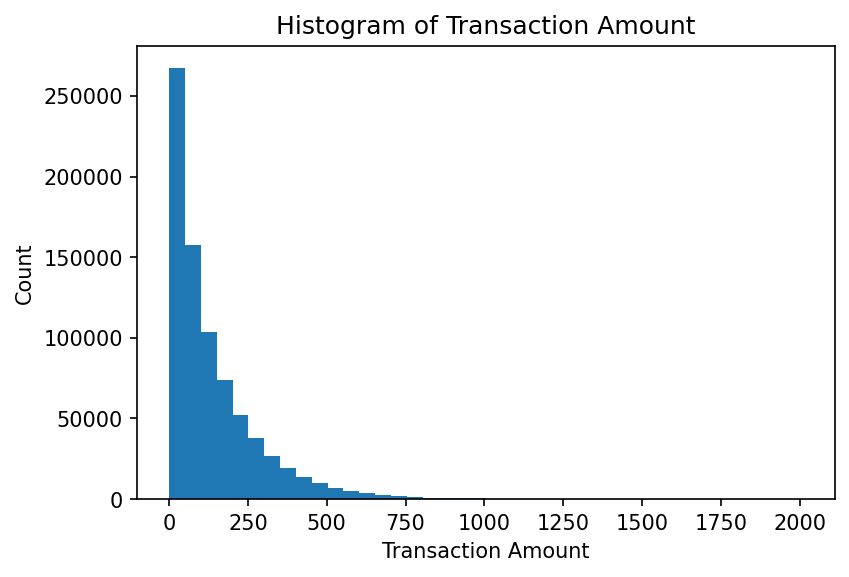

In [19]:
transactionAmount=trans['transactionAmount']

plt.figure(dpi=150)
plt.hist(transactionAmount,bins=40) #Drawing the hist graph
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.title('Histogram of Transaction Amount')
plt.show()

#### The plot below shows that there have a large amount of transactions with amount of 0

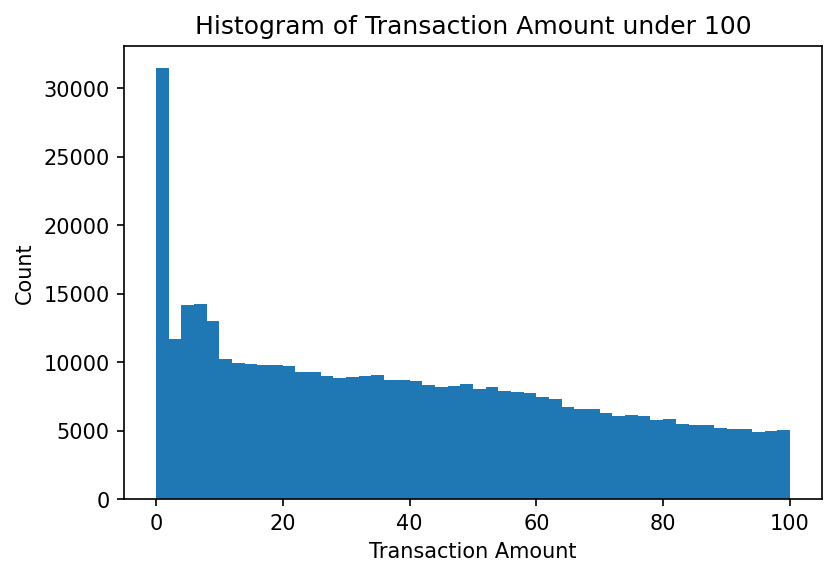

In [20]:
transactionAmount100=trans[(trans['transactionAmount']<100)]['transactionAmount'] #Select data with transaction amount is less than 100$
plt.figure(dpi=150)
plt.hist(transactionAmount100,bins=50)
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.title('Histogram of Transaction Amount under 100')
plt.show()

#### The histogram of transaction without 0

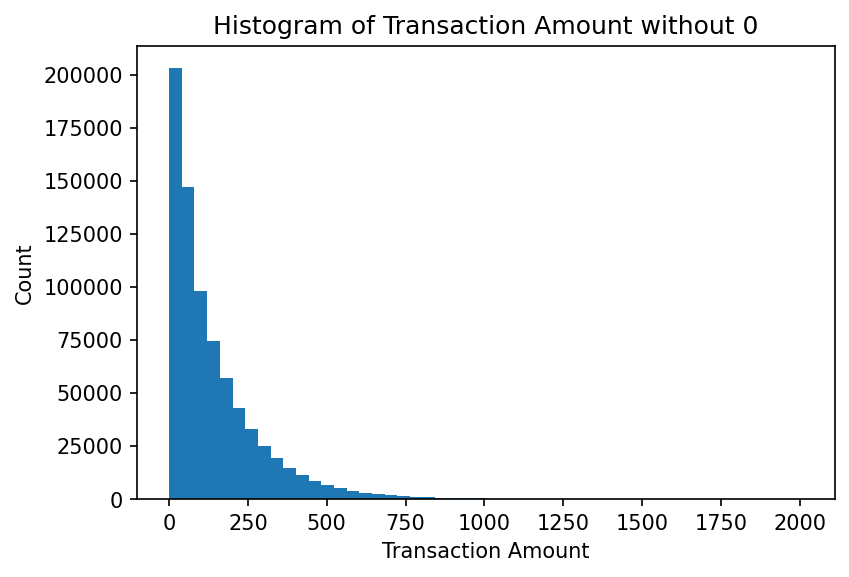

In [21]:
transactionAmount0=trans[(trans['transactionAmount']!=0)]['transactionAmount']
plt.figure(dpi=150)
plt.hist(transactionAmount0,bins=50)
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.title('Histogram of Transaction Amount without 0')
plt.show()

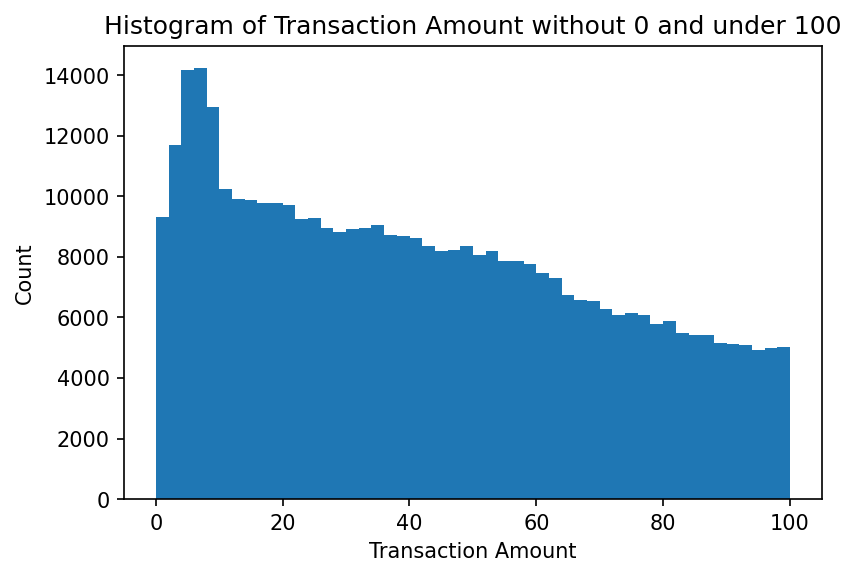

In [22]:
transactionAmount0=trans[(trans['transactionAmount']!=0) & (trans['transactionAmount']<100)]['transactionAmount']
#Select data with transaction amount is not 0$
plt.figure(dpi=150)
plt.hist(transactionAmount0,bins=50)
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.title('Histogram of Transaction Amount without 0 and under 100')
plt.show()

## Conclusion for Question 2

#### The majority of transactions are under 500$. There might have three reasons lead to this situation, 1)Few people would make large transactions using credit card. 2) Credit of credit card is limited, people would like to use cheque or debit card to make large transactions. 3) The society is becoming a cashless one, people would like to use credit card to make purchuse instead of using cash.

#### Also, I found that there are several transactions with 0. After reviewing the data, I found that all the cases of 0 are for address verification. In those transactions, there is still have fraud situations. So we cannot assume that it will not be a fraud if the transaction type is 'ADDRESS_VERIFICATION'

In [23]:
adv=trans[trans['transactionType']=='ADDRESS_VERIFICATION']
pd.value_counts(adv["isFraud"])

False    20053
True       116
Name: isFraud, dtype: int64

# Question 3: Data Wrangling - Duplicate Transactions

You will notice a number of what look like duplicated transactions in the data set. One type of duplicated transaction is a reversed transaction, where a purchase is followed by a reversal. Another example is a multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span.

•Can you programmatically identify reversed and multi-swipe transactions?  
•What total number of transactions and total dollar amount do you estimate for the reversed transactions? For the multi-swipe transactions?   (please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts)  
•Did you find anything interesting about either kind of transaction?


## Data Wrangling

#### The definition of data wrangling is a purchase is followed by a reversal. So I assume that the time to get a reversal is within 2 minutes after a purchase. I use 5 indexes(accountNumber, merchantCategoryCode, merchantName, transactionAmount and within2min) to find if the data is duplicated. Then, I use transactionType as the index to seperate wrangling and duplicate transactions.

In [24]:
#If transaction Date Time of different rows are within 2 minutes,their 'within2min' will be the same
trans['within2min']=trans.transactionDateTime.dt.floor('120s') #

wrangling=trans[trans.duplicated(subset=['accountNumber','merchantCategoryCode'
                                         ,'merchantName','transactionAmount','within2min'],keep=False)]

wrangling=wrangling[wrangling['transactionType']!='ADDRESS_VERIFICATION'] #Drop the data with ADDRESS_VERIFICATION

#diff is to find if different transaction time are different transaction type
#Without fill_value in the shift, some duplicate transactions will be included
wrangling['diff']=(wrangling['transactionType']!=wrangling['transactionType'].shift(-1,fill_value="PURCHASE")) 
wrangling=wrangling[wrangling['diff']==True] 

wrangling[['accountNumber','transactionDateTime','merchantName','transactionAmount','transactionType']].head(20)

accountNumber transactionDateTime            merchantName  \
132      984504651 2016-01-16 09:52:30  Planet Fitness #849960   
133      984504651 2016-01-16 09:53:15  Planet Fitness #849960   
890      984504651 2016-11-29 11:28:08                    Uber   
891      984504651 2016-11-29 11:28:42                    Uber   
899      984504651 2016-12-01 22:23:08                    Lyft   
900      984504651 2016-12-01 22:23:26                    Lyft   
1007     114896048 2016-01-26 13:12:45               sears.com   
1008     114896048 2016-01-26 13:13:27               sears.com   
1795     863358589 2016-04-06 01:56:11        Quizno's #491822   
1796     863358589 2016-04-06 01:56:38        Quizno's #491822   
2534     222396921 2016-06-07 12:52:34    Auntie Anne's #19289   
2535     222396921 2016-06-07 12:53:57    Auntie Anne's #19289   
2817     815239280 2016-04-01 06:22:13     Boston Cafe #465229   
2818     815239280 2016-04-01 06:22:24     Boston Cafe #465229   
2870     815239280 2016-08-22 17:09:20        South Restaurant   
2871     815239280 2016-08-22 17:09:54        South Restaurant   
3249     805566864 2016-03-12 18:18:50    Krispy Kreme #348894   
3250     805566864 2016-03-12 18:18:59    Krispy Kreme #348894   
3260     805566864 2016-03-18 07:26:27         Hardee's #49071   
3261     805566864 2016-03-18 07:27:19         Hardee's #49071   

      transactionAmount transactionType  
132              450.74        PURCHASE  
133              450.74        REVERSAL  
890             1041.75        PURCHASE  
891             1041.75        REVERSAL  
899               41.02        PURCHASE  
900               41.02        REVERSAL  
1007               2.70        PURCHASE  
1008               2.70        REVERSAL  
1795             306.67        PURCHASE  
1796             306.67        REVERSAL  
2534             112.60        PURCHASE  
2535             112.60        REVERSAL  
2817             454.21        PURCHASE  
2818             454.21        REVERSAL  
2870             284.41        PURCHASE  
2871             284.41        REVERSAL  
3249             257.31        PURCHASE  
3250             257.31        REVERSAL  
3260             425.78        PURCHASE  
3261             425.78        REVERSAL

In [25]:
print("The estimate number of transactions for reversed transactions is",len(wrangling[wrangling['transactionType']=='REVERSAL']))
print("The estimate amount of transactions for reversed transactions is",
      np.round(sum(wrangling[wrangling['transactionType']=='REVERSAL']['transactionAmount']),2))

The estimate number of transactions for reversed transactions is 1901
The estimate amount of transactions for reversed transactions is 270312.77


## Dupilcate Transactions  

#### I use 6 features to judge if the transactions are duplicated. I assume a duplicate transactions is the transactions happend within 2 minutes.

In [26]:
#trans['within2min']=trans.transactionDateTime.dt.floor('120s')
#If all 6 features are the same, I assume they are the duplicate transactions
trans['Duplicated']=trans.duplicated(subset=['within2min','accountNumber','merchantCategoryCode'
                                             ,'merchantName','transactionAmount','transactionType'],keep=False)

duplicate=trans[trans['Duplicated']==True]
duplicate[['accountNumber','transactionDateTime','merchantName','transactionAmount','transactionType']].head(20)

accountNumber transactionDateTime              merchantName  \
262      984504651 2016-03-12 06:34:13               AMC #706324   
263      984504651 2016-03-12 06:34:29               AMC #706324   
280      984504651 2016-03-18 13:56:20    Planet Fitness #692929   
281      984504651 2016-03-18 13:57:04    Planet Fitness #692929   
338      984504651 2016-04-08 22:20:33               WSC #994275   
339      984504651 2016-04-08 22:21:11               WSC #994275   
493      984504651 2016-06-14 18:28:35               WSC #374789   
494      984504651 2016-06-14 18:29:17               WSC #374789   
1437     114896048 2016-11-12 05:41:44                 sears.com   
1438     114896048 2016-11-12 05:41:47                 sears.com   
1787     863358589 2016-04-01 14:18:26       EZ Putt Putt #40513   
1788     863358589 2016-04-01 14:19:34       EZ Putt Putt #40513   
1883     863358589 2016-06-10 22:26:25   Universe Massage #74457   
1884     863358589 2016-06-10 22:27:09   Universe Massage #74457   
2138     863358589 2016-12-24 15:44:42  Universe Massage #320094   
2139     863358589 2016-12-24 15:44:51  Universe Massage #320094   
2354     782635414 2016-12-10 03:05:14           Virgin Airlines   
2355     782635414 2016-12-10 03:05:26           Virgin Airlines   
3018     101380713 2016-07-23 06:56:15                amazon.com   
3019     101380713 2016-07-23 06:57:42                amazon.com   

      transactionAmount transactionType  
262              118.52        PURCHASE  
263              118.52        PURCHASE  
280               26.71        PURCHASE  
281               26.71        PURCHASE  
338               43.21        PURCHASE  
339               43.21        PURCHASE  
493               35.48        PURCHASE  
494               35.48        PURCHASE  
1437              23.15        PURCHASE  
1438              23.15        PURCHASE  
1787             201.27        PURCHASE  
1788             201.27        PURCHASE  
1883             104.92        PURCHASE  
1884             104.92        PURCHASE  
2138             204.73        PURCHASE  
2139             204.73        PURCHASE  
2354              28.07        PURCHASE  
2355              28.07        PURCHASE  
3018              33.74        PURCHASE  
3019              33.74        PURCHASE

In [27]:
print("The estimate number of transactions for duplicate transactions is",int(len(duplicate)/2))
print("The estimate amount of transactions for duplicate transactions is",
      np.round(sum(duplicate['transactionAmount'])/2,2))

The estimate number of transactions for duplicate transactions is 2490
The estimate amount of transactions for duplicate transactions is 370634.35


## Conclusion of Question 3

#### If we consider 2 minutes as the time slot to define a Data Wrangling and Dupilcate Transactions, then the estimate numer of transactions for reversed transactions is 1901, the estimate amount is 270312.77 dollars. For the duplicate transactions, the estimate number of it is 2490 and the amount reached 370634.35 dollars. 

# Question 4: Model

•Each of the transactions in the dataset has a field called isFraud. Please build a predictive model to determine whether a given transaction will be fraudulent or not. Use as much of the data as you like (or all of it).  
•Provide an estimate of performance using an appropriate sample, and show your work.  
•Please explain your methodology (modeling algorithm/method used and why, what features/data you found useful, what questions you have, and what you would do next with more time)


## Model Selection

Due to the existence of non-numeric data in the dataset, SVM and logistic regression models cannot be used in this dataset (Maybe it can be used, but I will explain the reason why I didn't choose in the end). Because of the non-numeric data, I decided to use random forest as the prediction model to the dataset.

## Data Modification and Feature Selection

The data has a total of 12,417 fraud records and 773,946 non-fraud records. The difference of the two is too large. If the original data is used directly, the fraudulent data cannot be accurately trained, resulting in biased model predictions.So I select the same amount of data in the non-fraud data as the fraud data.

In [28]:
fraud=trans[trans['isFraud']==True]
no_fraud=trans[trans['isFraud']==False]
no_fraud_select=no_fraud.sample(len(fraud)) #random select data from non-fraud data
train_set=pd.concat([fraud,no_fraud_select],axis=0) #join two dataset into one as training_set for the model

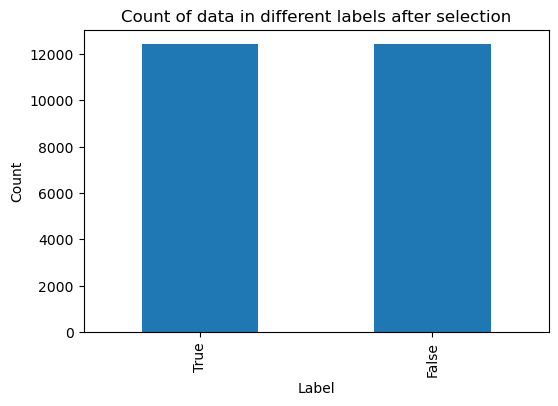

In [29]:
plt.figure(dpi=100)
pd.value_counts(train_set["isFraud"]).plot.bar()
plt.title("Count of data in different labels after selection")
plt.xlabel('Label')
plt.ylabel('Count')

plt.show()

Some catagory columns have no effect on the predictions, so we exclude these columns:  
    accountNumber  
    accountOpenDate  
    currentExpDate  
    customerId  
    dateOfLastAddressChange  
    transactionDateTime

### Entered CVV and Fraud

#### I think wrong entered CVV might be a detector for fraud, so I add a feature "isCVVmatch"

In [30]:
train_set['isCVVmatch']=train_set['cardCVV']==train_set['enteredCVV']

#### The two plots below shows that it has a higher chance to detect fraud when the customer input a wrong CVV number

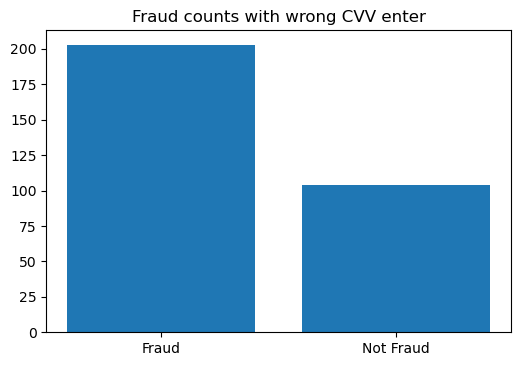

In [31]:
types=['Fraud','Not Fraud']
not_match = [len(train_set[(train_set['isCVVmatch']==False) & (train_set['isFraud']==True)]),
           len(train_set[(train_set['isCVVmatch']==False) & (train_set['isFraud']==False)])] 

plt.figure(dpi=100)
#plt.bar(range(len(match_count)), match_count, label='Match')
plt.title('Fraud counts with wrong CVV enter')
plt.bar(range(len(not_match)), not_match,tick_label = types)
plt.show()

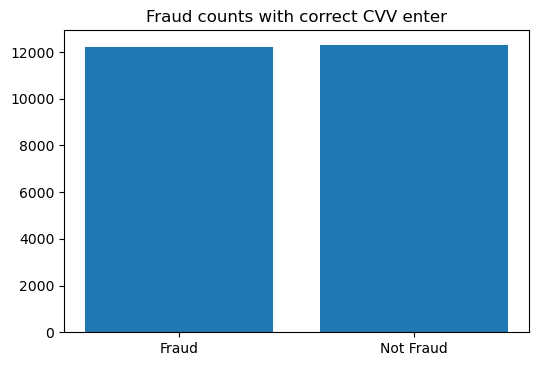

In [32]:
name_list = ['Fraud','Not Fraud']
match_count = [len(train_set[(train_set['isCVVmatch']==True) & (train_set['isFraud']==True)]),
           len(train_set[(train_set['isCVVmatch']==True) & (train_set['isFraud']==False)])] 

plt.figure(dpi=100)
plt.title('Fraud counts with correct CVV enter')
plt.bar(range(len(match_count)), match_count,tick_label = name_list)
plt.show()

### Card Present and Fraud

#### It has a higher chance that the transaction would be a fraud if the card is not presented

In [33]:
fraud_card=train_set[['isFraud','cardPresent']]
pd.crosstab(fraud_card['isFraud'],fraud_card['cardPresent'], margins=True)

cardPresent  False  True    All
isFraud                        
False         6889  5528  12417
True          8962  3455  12417
All          15851  8983  24834

### expirationDateKeyInMatch and Fraud

#### For column expirationDateKeyInMatch, there is basically no connections between 'expirationDateKeyInMatch' and 'isFraud'. 

In [34]:
fraud_expire=train_set[['isFraud','expirationDateKeyInMatch']]
pd.crosstab(fraud_expire['isFraud'],fraud_expire['expirationDateKeyInMatch']
            , margins=True)

expirationDateKeyInMatch  False  True    All
isFraud                                     
False                     12396    21  12417
True                      12404    13  12417
All                       24800    34  24834

### merchantCountryCode and Fraud

#### It is more likely to be a fraud transaction if the country is outside US (But I can't make definite decision since the volumn of data is to small compare with US).

In [35]:
fraud_country=train_set[['isFraud','merchantCountryCode']]
pd.crosstab(fraud_country['isFraud'],fraud_country['merchantCountryCode'], margins=True)

merchantCountryCode  CAN  MEX  PR     US    All
isFraud                                        
False                 29   41  23  12315  12408
True                  56   64  27  12188  12335
All                   85  105  50  24503  24743

### posEntryMode and Fraud

#### Nearly half of the fraud transactions with the posEntryMode 9, and posEntryMode 90 also is also might be a factor of judging fraud. While if the posEntryMode is 5 then it is less likely to be a fraud.

In [36]:
fraud_posEntryMode=train_set[['isFraud','posEntryMode']]
pd.crosstab(fraud_posEntryMode['isFraud'],fraud_posEntryMode['posEntryMode']
            , margins=True)

posEntryMode   2.0   5.0   9.0  80.0  90.0    All
isFraud                                          
False         3118  5070  3616   249   309  12362
True          3421  2456  5659   240   372  12148
All           6539  7526  9275   489   681  24510

### merchantCategoryCode and Fraud

In [37]:
fraud_merCatCode=train_set[['isFraud','merchantCategoryCode']]
pd.crosstab(fraud_merCatCode['isFraud'],fraud_merCatCode['merchantCategoryCode']
            , margins=True)


merchantCategoryCode  airline  auto  cable/phone  entertainment  fastfood  \
isFraud                                                                     
False                     263   326           15           1267      1799   
True                      534   273            0            961      1074   
All                       797   599           15           2228      2873   

merchantCategoryCode  food  food_delivery  fuel  furniture  gym  health  \
isFraud                                                                   
False                 1185             90   394        107   34     297   
True                  1014              0     0        103    0      90   
All                   2199             90   394        210   34     387   

merchantCategoryCode  hotels  mobileapps  online_gifts  online_retail  \
isFraud                                                                 
False                    538         235          1043           3158   
True                     250           0          1606           4938   
All                      788         235          2649           8096   

merchantCategoryCode  online_subscriptions  personal care  rideshare  \
isFraud                                                                
False                                  177            292        834   
True                                     0             86       1272   
All                                    177            378       2106   

merchantCategoryCode  subscriptions    All  
isFraud                                     
False                           363  12417  
True                            216  12417  
All                             579  24834

### transactionType and Fraud

#### For the transaction type, there is no obvious characteristic to see if a kind of transaction type is more likely to be a fraud transaction. So we will not include transactionType columns into the model. 

In [38]:
fraud_transtype=train_set[['isFraud','transactionType']]
pd.crosstab(fraud_transtype['isFraud'],fraud_transtype['transactionType']
            , margins=True)

transactionType  ADDRESS_VERIFICATION  PURCHASE  REVERSAL    All
isFraud                                                         
False                             330     11750       326  12406
True                              116     11950       337  12403
All                               446     23700       663  24809

### posConditionCode and Fraud

#### There is no obvious characteristic for posConditionCode to see if it is a fraud transaction. But when the code is 99, more fraud than the non-fraud.

In [39]:
fraud_posConMode=train_set[['isFraud','posConditionCode']]
pd.crosstab(fraud_posConMode['isFraud'],fraud_posConMode['posConditionCode']
            , margins=True)

posConditionCode    1.0   8.0  99.0    All
isFraud                                   
False              9894  2406   113  12413
True              10230  1936   229  12395
All               20124  4342   342  24808

### Measure data and Fraud

#### The following steps is to find out the correlations between measure data and isFraud. And above all measure features, 'transactionAmount' have high correlation index with Fraud(0.255082). So for the four measure data, I select 'transactionAmount' as a feature to the model.

In [40]:
measure_data=train_set[['availableMoney','creditLimit','currentBalance',
                    'transactionAmount','isFraud']]
measure_data.corr()

availableMoney  creditLimit  currentBalance  \
availableMoney           1.000000     0.824567        0.127036   
creditLimit              0.824567     1.000000        0.665931   
currentBalance           0.127036     0.665931        1.000000   
transactionAmount       -0.004942     0.001222        0.008659   
isFraud                 -0.008697     0.014473        0.036842   

                   transactionAmount   isFraud  
availableMoney             -0.004942 -0.008697  
creditLimit                 0.001222  0.014473  
currentBalance              0.008659  0.036842  
transactionAmount           1.000000  0.249285  
isFraud                     0.249285  1.000000

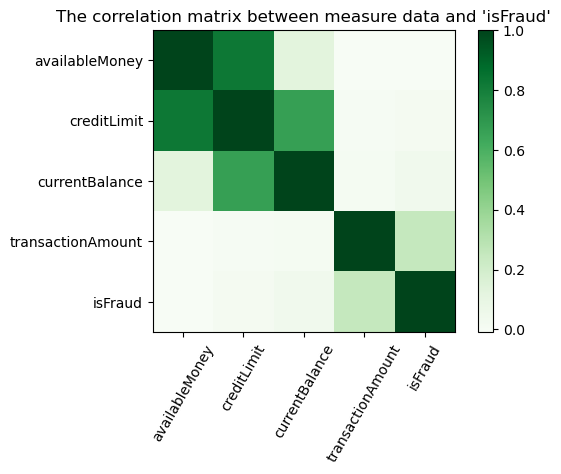

In [41]:
plt.figure(dpi=100)
plt.imshow(measure_data.corr(),cmap ='Greens')
plt.xticks(ticks = range(0,len(measure_data.keys()))
           ,labels=list(measure_data.keys()), rotation=60)
plt.yticks(ticks = range(0,len(measure_data.keys()))
           ,labels=list(measure_data.keys()))
plt.title("The correlation matrix between measure data and 'isFraud'")
plt.colorbar()
plt.show()

### Night Transaction and Fraud

#### I want to find out if night transaction is more likely to be a fraud, but during the night period (22~6), the number of fraud and not fraud are basically the same.

In [42]:
#I assume if time is later than 22 and earlier than 6, I consider it a night transaction
def is_night(x):
    if (x>=22) or (x<6):
        return True
    else:
        return False


In [43]:
train_set['is_night'] =[is_night(i) for i in list(train_set['transactionDateTime'].dt.hour)] #Judge if it is a night transaction

fraud_night=train_set[['isFraud','is_night']]
pd.crosstab(fraud_night['isFraud'],fraud_night['is_night']
            , margins=True)

is_night  False  True    All
isFraud                     
False      8288  4129  12417
True       8382  4035  12417
All       16670  8164  24834

## Conclution for Feature Selection

After analysis, I select total of 6 features as the input of the DecisionTree models.  
6 Features: isCVVmatch, cardPresent, merchantCountryCode, posConditionCode, transactionAmount, posEntryMode

## Ramdon Forest

### Data Selection

#### I first drop the line with null data, and select features seleced in the previous steps

In [44]:
train_set.dropna(inplace=True)
len(train_set)

24247

#### Data modification to suit the model

In [45]:
train_set=train_set[['isCVVmatch','cardPresent','merchantCountryCode','posConditionCode',
                'transactionAmount','posEntryMode','isFraud']]

for feature in ['isCVVmatch','cardPresent','merchantCountryCode','isFraud']: 
    enc = LabelEncoder() #Classify non-numeric quantities to corresponding integers
    enc.fit(train_set[feature])
    train_set[feature] = enc.transform(train_set[feature])
    
train_set.head(10)

isCVVmatch  cardPresent  merchantCountryCode posConditionCode  \
694            1            0                    3              8.0   
971            1            0                    3              1.0   
1072           1            0                    3              1.0   
1113           1            0                    3              1.0   
1321           1            0                    3              1.0   
1345           1            0                    3              1.0   
1346           1            0                    3              8.0   
1367           1            0                    3             99.0   
1623           1            0                    3              1.0   
1671           1            1                    3              1.0   

      transactionAmount posEntryMode  isFraud  
694              165.26          9.0        1  
971              298.85          9.0        1  
1072             406.89          9.0        1  
1113             439.31          9.0        1  
1321             266.09          9.0        1  
1345             195.28          2.0        1  
1346             241.73          9.0        1  
1367             104.34          9.0        1  
1623             345.45          2.0        1  
1671             148.32          5.0        1

#### Split data into training set and test set

In [46]:
input_data,label=train_set[['isCVVmatch','cardPresent','merchantCountryCode','posConditionCode',
                'transactionAmount','posEntryMode']], train_set['isFraud']
train_x,test_x,train_y,test_y=train_test_split(input_data,label,test_size=0.1) #90% of the data is training set
print(len(train_x))

21822


### Model

In [47]:
rfc=RandomForestClassifier(criterion = 'entropy', random_state = 40,n_estimators=200
                          ,max_depth=10) #This is the highest accuracy model and indexes I can find

rfc

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=200,
                       random_state=40)

#### Train the model

In [48]:
rfc.fit(train_x,train_y)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=200,
                       random_state=40)

In [67]:
joblib.dump(rfc, 'rfc.model')

['rfc.model']

#### Predict using testing set

In [49]:
predict=rfc.predict(test_x)
comfuse_matrix=pd.DataFrame(confusion_matrix(test_y,predict))
comfuse_matrix.rename(index={0:False,1:True},inplace=True)
comfuse_matrix.rename(columns={0:False,1:True},inplace=True)
comfuse_matrix

False  True
False    898   311
True     474   742

In [50]:
print("The accuracy of Random Forest is",rfc.score(test_x, test_y))

The accuracy of Random Forest is 0.6762886597938145


### Model Visualization

#### Visualization for the first 5 tree estimator

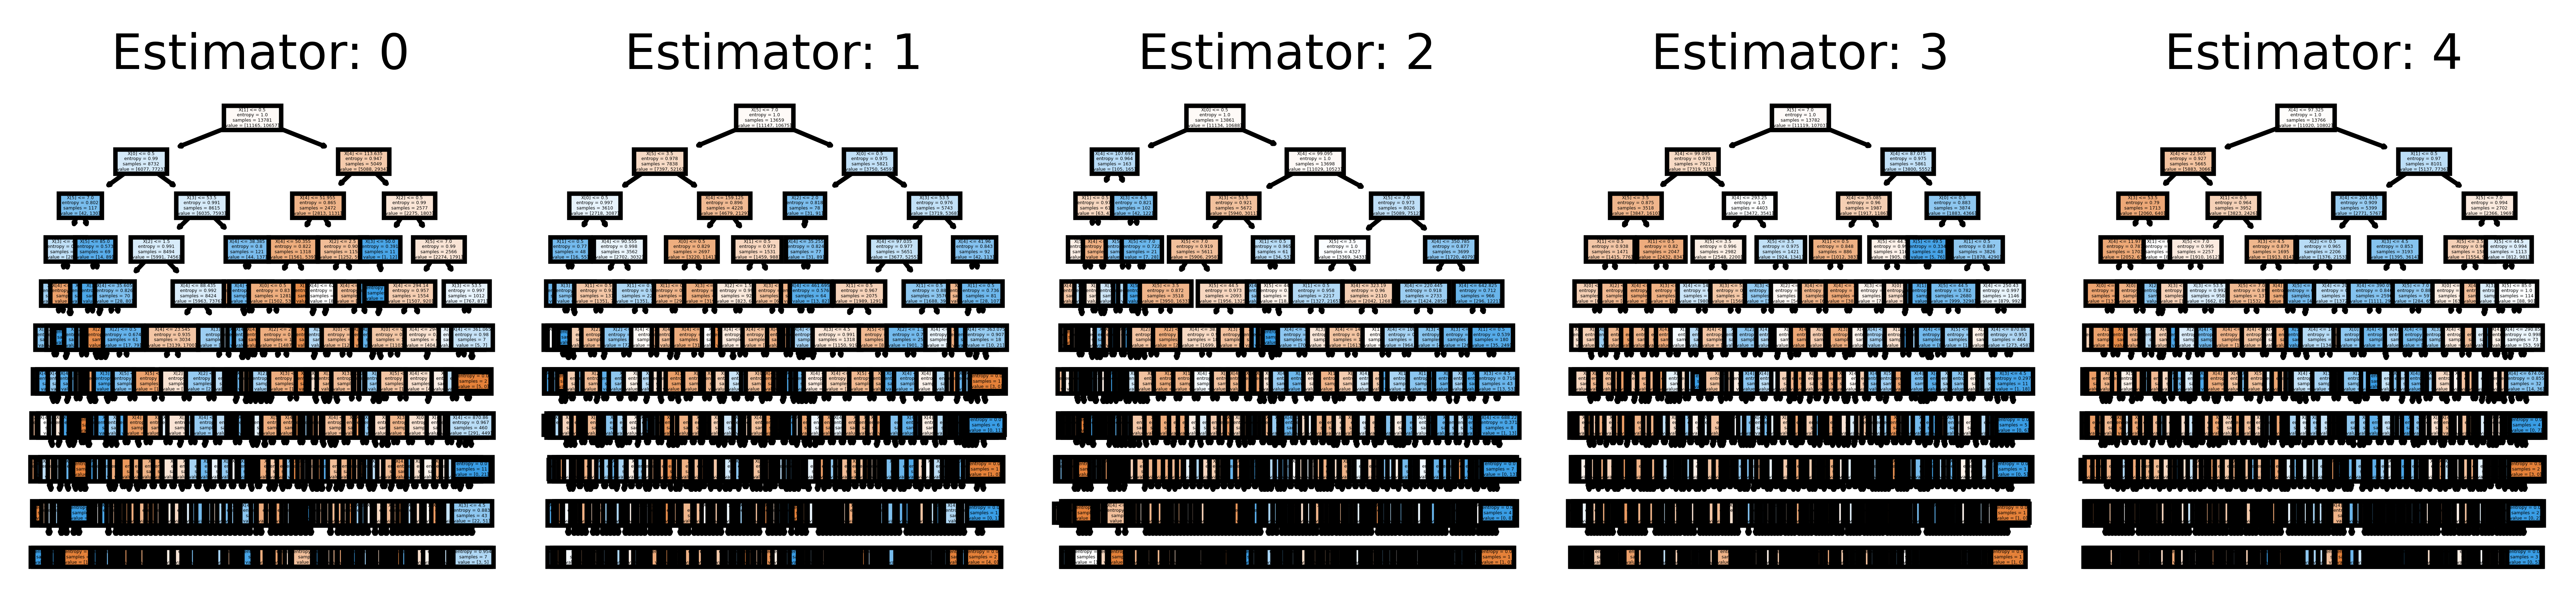

In [51]:
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for i in range(0, 5):
    tree.plot_tree(rfc.estimators_[i],
                   filled = True,
                   ax = axes[i]);

    axes[i].set_title('Estimator: ' + str(i), fontsize = 11) #plot the first 5 trees in the Random Forest model
plt.show()

#### The complete of first tree estimator

In [52]:
plt.figure(figsize=(100,100),dpi=100)
tree.plot_tree(rfc.estimators_[0])
plt.show()

#### As it shown in the plot below, 'transactionAmount' and 'posEntryMode' are the key factors to define if a transaction is a fraud

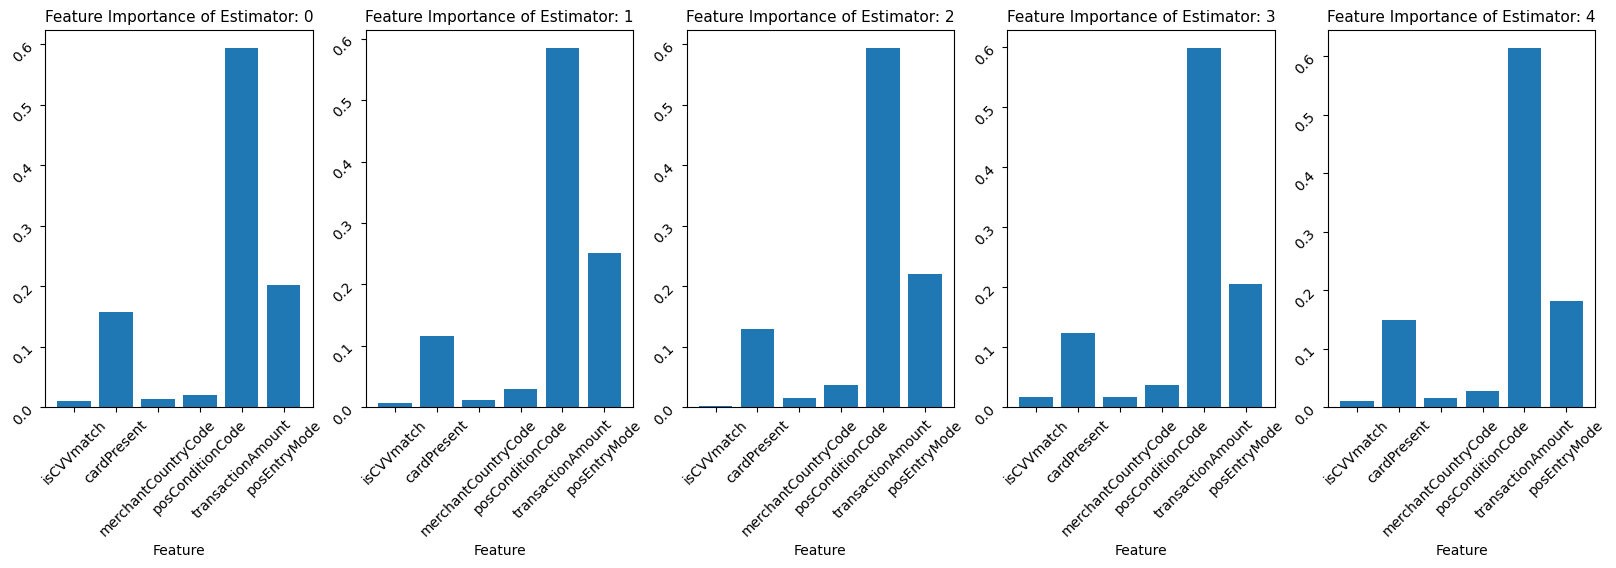

In [53]:
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (20,5), dpi=100)
for i in range(0, 5):
    axes[i].bar(['isCVVmatch','cardPresent','merchantCountryCode','posConditionCode',
                'transactionAmount','posEntryMode'],rfc.estimators_[i].feature_importances_) #plot the importance factors of 5 trees in the random forest
    axes[i].set_xlabel("Feature")
    axes[i].tick_params(labelrotation=45)
    axes[i].set_title('Feature Importance of Estimator: ' + str(i), fontsize = 11)
plt.show()

### Predict using the whole dataset

#### Transform the data to fit the model

In [54]:
trans_predict=trans.copy()
trans_predict.dropna(inplace=True)

trans_predict['isCVVmatch']=trans_predict['cardCVV']==trans_predict['enteredCVV']
trans_predict_x=trans_predict[['isCVVmatch','cardPresent','merchantCountryCode','posConditionCode',
                'transactionAmount','posEntryMode']]
trans_predict_y=trans_predict['isFraud']

#### Encoding the original dataset

In [55]:
for feature in ['isCVVmatch','cardPresent','merchantCountryCode']:
    enc = LabelEncoder() #Classify non-numeric quantities to corresponding integers
    enc.fit(trans_predict_x[feature])
    trans_predict_x[feature] = enc.transform(trans_predict_x[feature])

enc = LabelEncoder() #Classify non-numeric quantities to corresponding integers
enc.fit(trans_predict_y)
trans_predict_y = enc.transform(trans_predict_y)

/var/folders/5q/8ml1ydfd0c71_06wfbxcw9nh0000gn/T/ipykernel_13945/3735116876.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_predict_x[feature] = enc.transform(trans_predict_x[feature])


In [56]:
predict=rfc.predict(trans_predict_x)
comfuse_matrix=pd.DataFrame(confusion_matrix(trans_predict_y,predict))
comfuse_matrix.rename(index={0:False,1:True},inplace=True)
comfuse_matrix.rename(columns={0:False,1:True},inplace=True)
comfuse_matrix

False    True
False  558646  206056
True     4301    7665

In [57]:
print("The accuracy of Random Forest using the whole dataset is",rfc.score(trans_predict_x, trans_predict_y))

The accuracy of Random Forest using the whole dataset is 0.7291545422239618


## Conclution of Question 4

####  In Question 4, I used Random Forest as the basic model to make prediction. The accuracy using balanced data (number of fraud and not fraud records are the same) reached 0.684 while using original data is 0.724. In 6 features I seleced, 'transactionAmount' and 'posEntryMode' should be paid more attention because they are the key factors when predicting with Random Forest.  It's not a 'good enough' model because the accuracy is not high enough, especially consider that most cases are not fraud in original data. Maybe I can try different ways to get a higher accuracy with more times.

Claim: The accuracy number might be different from the conclusion because the training data are selected randomly, so each time you run the model, the result might be different.

## Question I Have

1. Some columns have no data in it, like 'echoBuffer', 'merchantZip',etc. I want to know why all these columns of data are null? Because I think merchantZip might be an important factor to predict fraud as some locations may have higher chance to fraud than other area.  
2. I'm not sure about the definition of reversed transaction. The definition is a purchase is followed by a reversal, but I'm not sure if there have other transactions between a purchase and a reversal can be defined as a reversed transaction.

## Model I Didn't Use

I used other two models before I finally used Decision Tree, which are Logistic Regression and SVM.

### Logistic Regression

The problem of Logistic Regression is that prediction accuracy is too low, which is around 0.5, same accuracy as guessing. Even though I changed the input, the result didn't get well. So I didn't use this model.

The following is Logistic Regression model's code

In [58]:
'''
temp=trans[['isCVVmatch','currentBalance','transactionAmount','isFraud']]
#temp=measure_data
fraud=temp[temp['isFraud']==True]
no_fraud=temp[temp['isFraud']==False]
no_fraud_select=no_fraud.sample(len(fraud))
train_set=pd.concat([fraud,no_fraud_select],axis=0)

train_set_x=train_set.drop('isFraud',axis=1,inplace=False)
train_set_y=train_set['isFraud']

lr=LogisticRegression()
lr.fit(train_set_x,train_set_y)
#result=lr.predict(fraud.drop('isFraud',axis=1,inplace=False))
#print(lr.score(train_set_x,train_set_y))
importance=lr.coef_.flatten()
print(importance)
'''

"\ntemp=trans[['isCVVmatch','currentBalance','transactionAmount','isFraud']]\n#temp=measure_data\nfraud=temp[temp['isFraud']==True]\nno_fraud=temp[temp['isFraud']==False]\nno_fraud_select=no_fraud.sample(len(fraud))\ntrain_set=pd.concat([fraud,no_fraud_select],axis=0)\n\ntrain_set_x=train_set.drop('isFraud',axis=1,inplace=False)\ntrain_set_y=train_set['isFraud']\n\nlr=LogisticRegression()\nlr.fit(train_set_x,train_set_y)\n#result=lr.predict(fraud.drop('isFraud',axis=1,inplace=False))\n#print(lr.score(train_set_x,train_set_y))\nimportance=lr.coef_.flatten()\nprint(importance)\n"

### SVM

SVM model is not a good fit with category data, I tried to transformed the data into a suitable one for the model, but it became too large for a dataset and took so long to get a result, so I put SVM out of my model list.

The following code is the way I transformed the data to fit SVM (Not recommend to run)

In [59]:
'''
trans=pd.read_csv('transactions.csv',encoding='utf-8',index_col=[0])
accountOpenDate=pd.get_dummies(trans['accountOpenDate'],drop_first=True)
currentExpDate=pd.get_dummies(trans['currentExpDate'],drop_first=True)
dateOfLastAddressChange=pd.get_dummies(trans['dateOfLastAddressChange'],drop_first=True)
merchantCategoryCode=pd.get_dummies(trans['merchantCategoryCode'],drop_first=True)
merchantName=pd.get_dummies(trans['merchantName'],drop_first=True)

trans.drop(['accountOpenDate','currentExpDate','dateOfLastAddressChange'
            ,'merchantCategoryCode','merchantName'],axis=1,inplace=True)

trans=pd.concat([trans,accountOpenDate,currentExpDate,dateOfLastAddressChange,
                merchantCategoryCode,merchantName],axis=1)
trans.first(10)
'''

"\ntrans=pd.read_csv('transactions.csv',encoding='utf-8',index_col=[0])\naccountOpenDate=pd.get_dummies(trans['accountOpenDate'],drop_first=True)\ncurrentExpDate=pd.get_dummies(trans['currentExpDate'],drop_first=True)\ndateOfLastAddressChange=pd.get_dummies(trans['dateOfLastAddressChange'],drop_first=True)\nmerchantCategoryCode=pd.get_dummies(trans['merchantCategoryCode'],drop_first=True)\nmerchantName=pd.get_dummies(trans['merchantName'],drop_first=True)\n\ntrans.drop(['accountOpenDate','currentExpDate','dateOfLastAddressChange'\n            ,'merchantCategoryCode','merchantName'],axis=1,inplace=True)\n\ntrans=pd.concat([trans,accountOpenDate,currentExpDate,dateOfLastAddressChange,\n                merchantCategoryCode,merchantName],axis=1)\ntrans.first(10)\n"

The code for SVM (Still not recommend to run, it will cost a lot of time)

In [60]:
'''
svms=SVC(kernel='linear')
svms.fit(train_set_x,train_set_y)
svms.score(temp.drop('isFraud',axis=1,inplace=False),temp['isFraud'])
'''

"\nsvms=SVC(kernel='linear')\nsvms.fit(train_set_x,train_set_y)\nsvms.score(temp.drop('isFraud',axis=1,inplace=False),temp['isFraud'])\n"

## If I Have More Time

If I have more time, I want to do the following things:  
1. I want to change the ratio of records between non-fraud and fraud to see if it will affect the accuracy. For example, the ration is 2:1 or 3:1.  
2. Use different models or optimize models I tried, like Logistic Regression and Naive Bayes.  
3. I didn't dig deep in the column 'merchantName' because there are too many stores or sevices providers, I want to figure out if 'merchantName' have effect when predicting a fraud transaction.